# Notebook that generates my README

In [1]:
from datetime import datetime

import jinja2
import matplotlib.pyplot as plt
import mplcyberpunk

import generate_data as gd

plt.style.use("cyberpunk")

In [2]:
_ = await gd.generate_data()

2026-01-19 12:07:40,921 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/python-kasa/repos?type=sources "HTTP/1.1 200 OK"


2026-01-19 12:07:40,984 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/topocm/repos?type=sources "HTTP/1.1 200 OK"


2026-01-19 12:07:40,994 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/python-adaptive/repos?type=sources "HTTP/1.1 200 OK"


2026-01-19 12:07:41,001 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/pipefunc/repos?type=sources "HTTP/1.1 200 OK"


2026-01-19 12:07:41,080 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/kwant-project/repos?type=sources "HTTP/1.1 200 OK"


2026-01-19 12:07:41,223 INFO:httpx:HTTP Request: GET https://api.github.com/users/basnijholt/repos?type=sources "HTTP/1.1 200 OK"


2026-01-19 12:07:41,776 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=2 "HTTP/1.1 200 OK"


2026-01-19 12:07:42,251 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=3 "HTTP/1.1 200 OK"


2026-01-19 12:07:42,812 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=4 "HTTP/1.1 200 OK"


2026-01-19 12:07:45,756 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=5 "HTTP/1.1 200 OK"


2026-01-19 12:07:48,504 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=6 "HTTP/1.1 200 OK"


2026-01-19 12:07:49,018 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=7 "HTTP/1.1 200 OK"


2026-01-19 12:07:49,502 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=8 "HTTP/1.1 200 OK"


2026-01-19 12:07:49,972 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=9 "HTTP/1.1 200 OK"


2026-01-19 12:07:50,492 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=10 "HTTP/1.1 200 OK"


2026-01-19 12:07:50,993 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=11 "HTTP/1.1 200 OK"


2026-01-19 12:07:51,541 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=12 "HTTP/1.1 200 OK"


2026-01-19 12:07:52,517 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=13 "HTTP/1.1 200 OK"


2026-01-19 12:07:52,978 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=14 "HTTP/1.1 200 OK"


2026-01-19 12:07:53,207 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=15 "HTTP/1.1 200 OK"


2026-01-19 12:07:53,635 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:53,863 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:54,124 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:54,434 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:54,656 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:54,931 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:55,709 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:55,992 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:56,222 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:56,466 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:56,828 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:57,031 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:57,290 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:57,497 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:57,708 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:57,980 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:58,196 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:58,436 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:58,695 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:58,935 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:59,194 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:59,477 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:07:59,789 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:00,049 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:00,259 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:00,461 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:00,730 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:01,003 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:01,294 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:01,606 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:01,795 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:02,455 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:02,726 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:02,962 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:03,221 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:03,490 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:03,716 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:03,938 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:04,201 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:04,494 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:04,728 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:05,029 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:05,217 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:05,480 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:05,747 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:05,991 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:06,254 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:06,498 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:06,865 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:07,071 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:07,297 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:07,614 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:08,028 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:08,280 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:08,502 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:08,750 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:09,015 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:09,248 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:09,521 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:09,799 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:10,078 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:10,281 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:10,524 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:10,740 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:11,032 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:11,212 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:11,429 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:11,675 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:11,906 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:12,141 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:12,558 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:12,838 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:13,074 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:13,305 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:13,607 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:13,812 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:14,018 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:14,271 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:14,470 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:14,749 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:14,979 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:15,220 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:15,623 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:15,874 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:16,144 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:16,407 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:16,685 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:16,882 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:17,055 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:17,359 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:17,966 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:18,178 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:18,389 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:18,603 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:18,863 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:19,138 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:19,376 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:19,611 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:19,949 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:20,203 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:20,428 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:20,661 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:20,866 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:21,138 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:21,387 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:21,566 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:21,868 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:22,095 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:22,386 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:22,616 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:22,842 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:23,124 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:23,387 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:23,589 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:23,839 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:24,123 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:24,316 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:24,575 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:25,001 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:25,260 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:25,463 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:25,722 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:25,911 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:26,102 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:26,359 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:26,575 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:26,852 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:27,154 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:27,370 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:27,598 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:27,822 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:28,125 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:28,388 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:28,642 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:28,820 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:29,191 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:29,357 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-01-19 12:08:29,564 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


In [3]:
data = gd.load_data()
repos = data.repos
stargazers = data.stargazers

## Number of stars ⭐️

In [4]:
most_stars_strs = [
    f"{i+1}. [{repo['full_name']}](https://github.com/{repo['full_name']}/), {repo['stargazers_count']} ⭐️s"
    for i, repo in enumerate(stargazers[:20])
]

most_stars_strs_summary, most_stars_strs_rest = gd.split(most_stars_strs, 5)

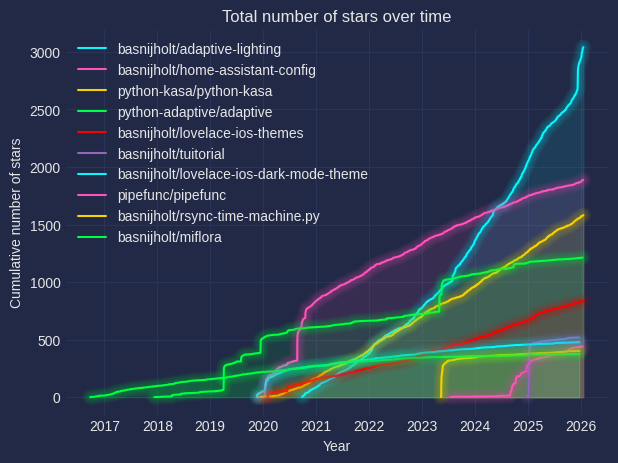

In [5]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_xlabel("Year")
ax.set_ylabel("Cumulative number of stars")
ax.set_title("Total number of stars over time")

for star_info in stargazers[:10]:
    dates = star_info["dates"]
    n_stars = list(range(1, len(dates) + 1))
    ax.plot(dates, n_stars, label=star_info["full_name"])
ax.legend()
mplcyberpunk.add_glow_effects()
plt.savefig("stars_over_time_per_repo.png")

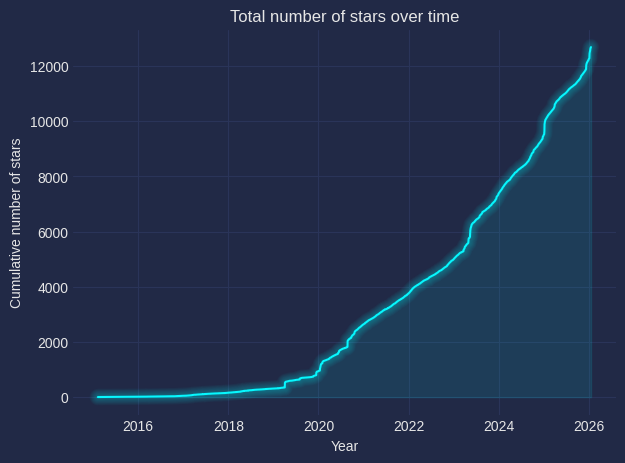

In [6]:
all_dates = sorted([date for star_info in stargazers for date in star_info["dates"]])
n_stars = list(range(1, len(all_dates) + 1))

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(all_dates, n_stars)
ax.set_xlabel("Year")
ax.set_ylabel("Cumulative number of stars")
ax.set_title("Total number of stars over time")
mplcyberpunk.add_glow_effects()
plt.savefig("stars_over_time.png")

In [7]:
# gd.to_plotly_json()

# import plotly.graph_objs as go
# from plotly.subplots import make_subplots

# with open("data/traces_data.json", "r") as infile:
#     traces_data = json.load(infile)
# fig = make_subplots()
# for trace_data in traces_data:
#     trace = go.Scatter(**trace_data)
#     fig.add_trace(trace)
# fig.update_layout(
#     title="Cumulative number of stars over time",
#     xaxis_title="Date",
#     yaxis_title="Number of stars",
# )
# fig.show()


## Render template

In [8]:
with open("README.jinja2", "r") as f:
  template = f.read()
txt = jinja2.Template(template).render(
    most_stars_strs_summary=most_stars_strs_summary,
    most_stars_strs_rest=most_stars_strs_rest,
    now=str(datetime.now()),
)
with open("README.md", "w") as f:
    f.write(txt)
print(txt)

# Bas Nijholt 👋

- 👷🏻‍♂️ Currently at [IonQ](https://ionq.com/), doing my bit in building a quantum computer, before that I was at [Microsoft Quantum](https://quantum.microsoft.com/).
- 🌟 A deep dive into computational topological quantum mechanics earned me [my PhD](https://github.com/basnijholt/thesis).
- 🎨 I've crafted [a](https://github.com/basnijholt/adaptive-lighting) [few](https://github.com/basnijholt/aiokef) [libraries](https://github.com/basnijholt/miflora) for Home Assistant, making home automation a bit more fun.
- ⚒️ Made other tools [speed up](https://github.com/python-adaptive/adaptive) and [massively parallelize](https://github.com/basnijholt/adaptive-scheduler) numerical simulations.
- 🏅 Very passionate about open-source, software quality, user experience, and smooth performance.
- 🐍 Python is my go-to language in most of my projects.
- Some of my favorite creations:
  - 📈 **[python-adaptive/adaptive](https://github.com/python-adaptive/adaptive/)**: Parallel active lea